In [103]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import scipy.stats as ss
import matplotlib 
import pickle
import os
import re

In [104]:
# Cell to contain all defined functions
def rename_columns(dataframe):
    df = dataframe
    cols = [c.replace(" ", "_").lower() for c in df.columns]
    cols[3] = "modified_sequence"
    df.columns = cols

def map_sample_names(dataframe):
    df = dataframe
    samples = list(set(df.file_name))
    regs = [r"\d*\_DIA\_", r"\.raw", r"\-"]
    res = {}
    for sample in samples:
        new_name = sample
        for reg in regs:
            new_name = re.sub(reg, "", new_name)
        if new_name not in res:
            res[sample] = new_name.lower()
    df.file_name = df.file_name.map(res)

def df_reduce_samples(samples, dataframe):
    df = dataframe
    return df[df.file_name.isin(samples)]

def pep_in_all_samples(peptide, mz, sample_list, dataframe):
    df = dataframe
    df = df[(df.modified_sequence==peptide) & 
            (df.precursor_mz==mz) & 
            (df.total_area_ms1 != 0)]
    return set(df.file_name)==set(sample_list), df.index.tolist()

def get_most_intense_charge(peptide, dataframe):
    df = dataframe
    df = df[df.modified_sequence==peptide]
    intensity = (df.total_area_ms1.describe()["max"])
    z = df[df.total_area_ms1==intensity]["precursor_charge"].item()
    return df[df.precursor_charge==z].index.tolist()

def collapse_proteins(sample_list, dataframe):
    df = dataframe
    proteins = list(set(df.protein_name))
    top = {}
    for sample in sample_list:
        base = {}
        sub = df[df.file_name==sample]
        proteins = list(set(df.protein_name))
        for protein in proteins:
            sub2 = sub[sub.protein_name==protein]
            base[protein] = sub2.total_area_ms1.sum()
        top[sample] = base 
    return pd.DataFrame(top)

def reduce_axis_labels(ax, factor, vert):    
    if vert.lower() == "x":
        plt.setp(ax.xaxis.get_ticklabels(), visible=False)    
        for label in ax.xaxis.get_ticklabels()[factor-1::factor]:        
            label.set_visible(True)
    elif vert.lower() == "y":
        plt.setp(ax.yaxis.get_ticklabels(), visible=False)    
        for label in ax.yaxis.get_ticklabels()[factor-1::factor]:        
            label.set_visible(True)

def has_x_peptides(dataframe, x, sample_list):
    df = dataframe
    counts = df.protein_name.value_counts()/len(sample_list)
    return df[df.protein_name.isin(counts[counts>=x].index)]

def remove_outliers(array, max_devs):
    mean = np.mean(array)
    std_dev = np.std(array)
    dist = abs(array-mean)
    not_outlier = dist < max_devs * std_dev
    return np.where(dist < max_devs * std_dev)

def clean_arrays(xs, ys):
    val_x = remove_outliers(np.log2(xs), 2)[0]
    val_y = remove_outliers(np.log2(ys), 2)[0]
    ids = [i for i in val_x if i in val_y]
    return ids

In [105]:
file = r"E:\Research\Data Workup\CSF_Skyline_Quant_20200124\01272020_CSF_DIA_Top2top3_0.6_0.6.csv"
df = pd.read_csv(file)
rename_columns(df)
map_sample_names(df)
ms1 = df[df.fragment_ion=="precursor"]
ms1.head()

,file_name,protein_name,peptide_sequence,modified_sequence,precursor_mz,precursor_charge,fragment_ion,area,total_area_ms1,total_area_fragment
0,ctrl1_rep1,sp|A0A0A0MS15|HV349_HUMAN,SIAYLQMNSLK,SIAYLQMNSLK,634.33938,2,precursor,23859698,53500528,257655808
1,ctrl1_rep2,sp|A0A0A0MS15|HV349_HUMAN,SIAYLQMNSLK,SIAYLQMNSLK,634.33938,2,precursor,29800830,100641864,35892984
2,ctrl2_rep1,sp|A0A0A0MS15|HV349_HUMAN,SIAYLQMNSLK,SIAYLQMNSLK,634.33938,2,precursor,151988,3895099,99978976
3,ctrl2_rep2,sp|A0A0A0MS15|HV349_HUMAN,SIAYLQMNSLK,SIAYLQMNSLK,634.33938,2,precursor,0,3212994,398603584
4,ctrl3_rep1,sp|A0A0A0MS15|HV349_HUMAN,SIAYLQMNSLK,SIAYLQMNSLK,634.33938,2,precursor,1483501,4060443,214149616


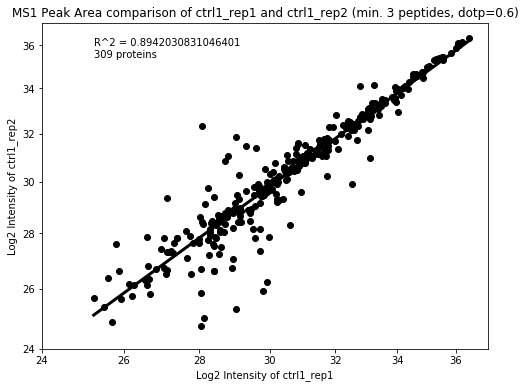

In [113]:
# comparing technical_replicates ctrl1_1 and ctrl1_2
samples = ["ctrl1_rep1", "ctrl1_rep2"]
ctrl1_ms1 = df_reduce_samples(samples, ms1)
reduced_ctrl1 = ctrl1_ms1[["modified_sequence", "precursor_mz"]].drop_duplicates()

idxs = []
for r in zip(reduced_ctrl1.modified_sequence, reduced_ctrl1.precursor_mz):
    sequence, mz = r[0], r[1]
    in_all, indexes = pep_in_all_samples(sequence, mz, samples, ctrl1_ms1)
    if in_all:
        idxs.extend(indexes)
ctrl1_valid_peps = ctrl1_ms1.loc[idxs, :]
###
ctrl1_with_3 = has_x_peptides(ctrl1_valid_peps, 3, samples)

charge_red_idx = []
for pep in list(set(ctrl1_with_3.modified_sequence)):
    z = get_most_intense_charge(pep, ctrl1_with_3)
    charge_red_idx.extend(z)
ctrl1_with_3 = ctrl1_with_3.loc[charge_red_idx, :]

d = collapse_proteins(samples, ctrl1_with_3)
xs, ys = d[samples[0]].values, d[samples[1]].values
ids = clean_arrays(xs, ys)
xs, ys = np.log2(xs[ids]), np.log2(ys[ids])
fig, ax = plt.subplots(figsize=(8, 6))
ax.set_xscale('symlog', basex=2)
ax.set_yscale('symlog', basey=2)
ax.set_title(f"MS1 Peak Area comparison of {samples[0]} and {samples[1]} (min. 3 peptides, dotp=0.6)")
ax.set_xlabel(f"Log2 Intensity of {samples[0]}")
ax.set_ylabel(f"Log2 Intensity of {samples[1]}")
ax.scatter(xs, ys, color="k")
slope, intercept, r_value, p_value, std_err = ss.linregress(xs, ys)
ax.plot([min(xs), max(xs)],[min(xs)*slope+intercept, max(xs)*slope+intercept],
        linewidth=3, color="k")
texstr = [f"R^2 = {r_value**2}", f"{len(xs)} proteins"]
ax.text(min(xs), max(ys), "\n".join(texstr), verticalalignment='top')
ax.set_xticks(np.arange(24, 38, step=((38-24)//6)))
ax.get_xaxis().set_major_formatter(matplotlib.ticker.LogFormatter(base=2))
ax.set_yticks(np.arange(24, 38, step=((38-24)//6)))
ax.get_yaxis().set_major_formatter(matplotlib.ticker.LogFormatter(base=2))

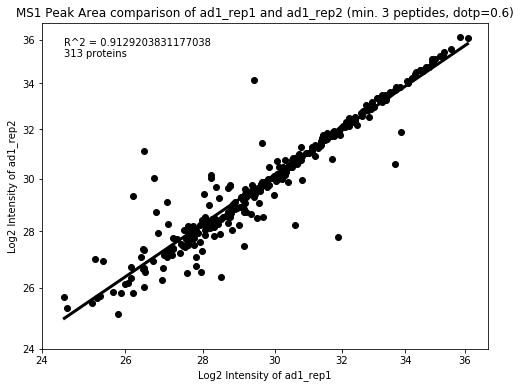

In [111]:
# comparing technical_replicates ad1_1 and ad1_2
samples = ["ad1_rep1", "ad1_rep2"]
ad1_ms1 = df_reduce_samples(samples, ms1)
reduced_ad1 = ad1_ms1[["modified_sequence", "precursor_mz"]].drop_duplicates()

idxs = []
for r in zip(reduced_ad1.modified_sequence, reduced_ad1.precursor_mz):
    sequence, mz = r[0], r[1]
    in_all, indexes = pep_in_all_samples(sequence, mz, samples, ad1_ms1)
    if in_all:
        idxs.extend(indexes)
ad1_valid_peps = ad1_ms1.loc[idxs, :]
###
ad1_with_3 = has_x_peptides(ad1_valid_peps, 3, samples)

charge_red_idx = []
for pep in list(set(ad1_with_3.modified_sequence)):
    z = get_most_intense_charge(pep, ad1_with_3)
    charge_red_idx.extend(z)
ad1_with_3 = ad1_with_3.loc[charge_red_idx, :]

d = collapse_proteins(samples, ad1_with_3)
xs, ys = d[samples[0]].values, d[samples[1]].values
ids = clean_arrays(xs, ys)
xs, ys = np.log2(xs[ids]), np.log2(ys[ids])
fig, ax = plt.subplots(figsize=(8, 6))
ax.set_xscale('symlog', basex=2)
ax.set_yscale('symlog', basey=2)
ax.set_title(f"MS1 Peak Area comparison of {samples[0]} and {samples[1]} (min. 3 peptides, dotp=0.6)")
ax.set_xlabel(f"Log2 Intensity of {samples[0]}")
ax.set_ylabel(f"Log2 Intensity of {samples[1]}")
ax.scatter(xs, ys, color="k")
slope, intercept, r_value, p_value, std_err = ss.linregress(xs, ys)
ax.plot([min(xs), max(xs)],[min(xs)*slope+intercept, max(xs)*slope+intercept],
        linewidth=3, color="k")
texstr = [f"R^2 = {r_value**2}", f"{len(xs)} proteins"]
ax.text(min(xs), max(ys), "\n".join(texstr), verticalalignment='top')
ax.set_xticks(np.arange(24, 38, step=((38-24)//6)))
ax.get_xaxis().set_major_formatter(matplotlib.ticker.LogFormatter(base=2))
ax.set_yticks(np.arange(24, 38, step=((38-24)//6)))
ax.get_yaxis().set_major_formatter(matplotlib.ticker.LogFormatter(base=2))

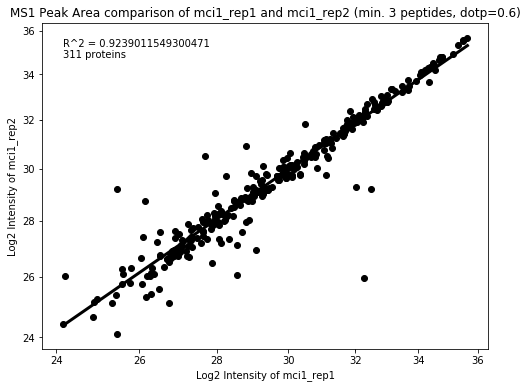

In [112]:
# comparing technical_replicates mci1_1 and mci1_2
samples = ["mci1_rep1", "mci1_rep2"]
mci1_ms1 = df_reduce_samples(samples, ms1)
reduced_mci1 = mci1_ms1[["modified_sequence", "precursor_mz"]].drop_duplicates()

idxs = []
for r in zip(reduced_mci1.modified_sequence, reduced_mci1.precursor_mz):
    sequence, mz = r[0], r[1]
    in_all, indexes = pep_in_all_samples(sequence, mz, samples, mci1_ms1)
    if in_all:
        idxs.extend(indexes)
mci1_valid_peps = mci1_ms1.loc[idxs, :]
###
mci1_with_3 = has_x_peptides(mci1_valid_peps, 3, samples)

charge_red_idx = []
for pep in list(set(mci1_with_3.modified_sequence)):
    z = get_most_intense_charge(pep, mci1_with_3)
    charge_red_idx.extend(z)
mci1_with_3 = mci1_with_3.loc[charge_red_idx, :]

d = collapse_proteins(samples, mci1_with_3)
xs, ys = d[samples[0]].values, d[samples[1]].values
ids = clean_arrays(xs, ys)
xs, ys = np.log2(xs[ids]), np.log2(ys[ids])
fig, ax = plt.subplots(figsize=(8, 6))
ax.set_xscale('symlog', basex=2)
ax.set_yscale('symlog', basey=2)
ax.set_title(f"MS1 Peak Area comparison of {samples[0]} and {samples[1]} (min. 3 peptides, dotp=0.6)")
ax.set_xlabel(f"Log2 Intensity of {samples[0]}")
ax.set_ylabel(f"Log2 Intensity of {samples[1]}")
ax.scatter(xs, ys, color="k")
slope, intercept, r_value, p_value, std_err = ss.linregress(xs, ys)
ax.plot([min(xs), max(xs)],[min(xs)*slope+intercept, max(xs)*slope+intercept],
        linewidth=3, color="k")
texstr = [f"R^2 = {r_value**2}", f"{len(xs)} proteins"]
ax.text(min(xs), max(ys), "\n".join(texstr), verticalalignment='top')
ax.set_xticks(np.arange(24, 38, step=((38-24)//6)))
ax.get_xaxis().set_major_formatter(matplotlib.ticker.LogFormatter(base=2))
ax.set_yticks(np.arange(24, 38, step=((38-24)//6)))
ax.get_yaxis().set_major_formatter(matplotlib.ticker.LogFormatter(base=2))

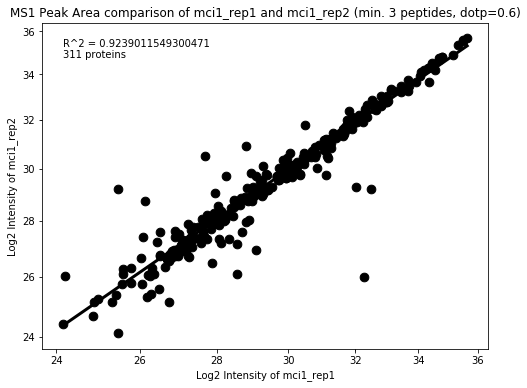

In [109]:
fig, ax = plt.subplots(figsize=(8, 6))
ax.set_xscale('symlog', basex=2)
ax.set_yscale('symlog', basey=2)
ax.set_title(f"MS1 Peak Area comparison of {samples[0]} and {samples[1]} (min. 3 peptides, dotp=0.6)")
ax.set_xlabel(f"Log2 Intensity of {samples[0]}")
ax.set_ylabel(f"Log2 Intensity of {samples[1]}")
ax.scatter(xs, ys, s=75, color="k")
slope, intercept, r_value, p_value, std_err = ss.linregress(xs, ys)
ax.plot([min(xs), max(xs)],[min(xs)*slope+intercept, max(xs)*slope+intercept],
        linewidth=3, color="k")
texstr = [f"R^2 = {r_value**2}", f"{len(xs)} proteins"]
ax.text(min(xs), max(ys), "\n".join(texstr), verticalalignment='top')
ax.set_xticks(np.arange(24, 38, step=((38-24)//6)))
ax.get_xaxis().set_major_formatter(matplotlib.ticker.LogFormatter(base=2))
ax.set_yticks(np.arange(24, 38, step=((38-24)//6)))
ax.get_yaxis().set_major_formatter(matplotlib.ticker.LogFormatter(base=2))